In [5]:
from init import *
import os
import numpy as np
from torch import nn
import torch
from modules.operates.ops import conv3x3,conv1x1,residualBlock
from modules.blocks.yolo_blocks import C3, Conv
from modules.blocks.input_blocks import MultiKernelInput,CovAndHW,Fusion2Branch,Fusion3Branch
from lossers import dice_loss

In [3]:
class Fusion2Backbone(nn.Module):
    def __init__(self,c1,ns=[],ss=[],c_size=True):
        super(Fusion2Backbone,self).__init__()
        
        self.seq = nn.Sequential()
        self.seq1 = nn.Sequential()
        self.seq2 = nn.Sequential()
        c=c1
        for i,(n,s) in enumerate(zip(ns,ss)):
            subseq = nn.Sequential()
            for _ in range(n):
                subseq.add_module('c3_'+str(i)+'_'+str(_),C3(c1,c,1))
            
            if not c_size: c*=s
            self.seq.add_module('subseq_'+str(i),subseq)
            self.seq1.add_module('c1_'+str(i),Conv(c1,c,k=3,s=s,p=1))
            c1=c
            
            self.seq2.add_module('c1_'+str(i),Conv(c1*2,c1,k=3,s=1,p=1))
        self.cov_act1 = Cov_Act(c1,c,3,1,1)
        self.cov_act2 = Cov_Act(c1,c,3,1,1)
        
    def forward(self,x1,x2):
        for m,m1,m2 in zip(self.seq,self.seq1,self.seq2):
            x1 = m(x1)
            y1 = m1(x1)
            
            x2 = m(x2)
            y2 = m1(x2)
            x1 = torch.cat([y1*0.8,y2*0.2],1)
            x2 = torch.cat([y2*0.8,y1*0.2],1)
            
            x1 = m2(x1)
            x2 = m2(x2)
            x1 = self.cov_act1(x1)
            x2 = self.cov_act2(x2)
        return x1,x2
    
class Cov_Act(nn.Module):
    def __init__(self,c1,c2,k,s,p):
        super(Cov_Act,self).__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, p, groups=1, bias=False)
        # self.bn = nn.BatchNorm2d(c2,eps=0.001,momentum=0.03)
        self.act = nn.SiLU()
    def forward(self,x):
        x = self.conv(x)
        x = self.act(x)
        return x



class Model(nn.Module):
    def __init__(self, ch=3):
        super(Model, self).__init__()
        self.ch=ch
        self.m_ch = 64
        self.out_ch=1
        self.MI = MultiKernelInput(3, self.m_ch)
        self.model = nn.Sequential()
        self.fb = Fusion2Backbone(self.m_ch,ns=[6,1,1,6,1,1],ss=[1,1,1,1,1,1])
        self.cov1 =  Conv(self.m_ch,self.out_ch,3,1,1)
        self.cov2 =  Conv(self.m_ch,self.out_ch,3,1,1)
        
    def forward(self, x1=None,x2=None):
        if x2 is None:  x2 = x1.copy()
        x1 = self.MI(x1)
        x2 = self.MI(x2)        
        x1,x2 = self.fb(x1,x2)
        x1 = self.cov1(x1)
        x2 = self.cov2(x2)
        return x1,x2
    
# blocks=[conv3x3,residualBlock,conv3x3,residualBlock,conv3x3,residualBlock,conv3x3], repeats=[1,3,1,3,1,3,1],downs=[1,1,2,1,1,1,1]
# model = Model(3)
# imgs = torch.zeros((1,3,640,640))
# r1,r2 = model(imgs,imgs)
# print(r1.shape)

In [3]:
import  torchvision
resize = torchvision.transforms.Resize((320,320), interpolation=2)

device = 'cuda:5'
epochs=500 

fb = Model(3)
fb = fb.train()
fb=fb.to(device)
fb = fb.half()

cfg['training']['batch_size']=4
cfg['training']['n_workers']=16
cfg['data']['img_rows']=640
cfg['data']['img_cols']=640
cfg0['training']['optimizer']['lr']=0.001

n_claess,train_loader, val_loder = get_dataloader(cfg)
optimizer, scheduler = get_optimizer_scheduler(fb)


for epoch  in  range(epochs): 
    losses =[]
    # optimizer.zero_grad()
    for images in train_loader:
        optimizer.zero_grad()
        t1 = images['image_mask'].to(device).half()
        t2 = images['image_mask'].to(device).half()
        t1_b = images['image'].to(device).half()
        t2_b = images['image'].to(device).half()
        
        r1,r2 = fb(t1,t2)
        t1_b = resize(t1_b)
        t2_b = resize(t2_b)
        # loss = (torch.abs(r1-t1_b).double().sum()/r1.shape.numel() + torch.abs(r2-t2_b).double().sum()/r2.shape.numel())/1.0
        loss = criterion(r1,t1_b)\
                           + dice_loss(F.softmax(r1, dim=1).float(),
                                       F.one_hot(t1_b.squeeze(1), 3).permute(0, 3, 1, 2).float(),
                                       multiclass=True)\
                +criterion(r2,t2_b)\
                           + dice_loss(F.softmax(r2, dim=1).float(),
                                       F.one_hot(t2_b.squeeze(1), 3).permute(0, 3, 1, 2).float(),
                                       multiclass=True)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        # optimizer.zero_grad()
 
        losses.append(loss.detach().cpu().numpy())
    print('epoch'+str(epoch)+' :', np.sum(losses)/len(losses))

/home/wanghaifeng/.local/lib/python3.9/site-packages/torchvision/transforms/transforms.py:287: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


epoch0 : 13.71011038246244


In [6]:
def model_data_device_precision(model_datas=[],device='cuda:7',precision='half'):
    for i,md in enumerate(model_datas):
        md = md.to(device)
        
        if precision == 'half':
            md = md.half()
        elif precision == 'float':
            md  = md.float()
        model_datas[i] =md
    return model_datas

In [4]:
#     fb = fb.train().half()
#     for _ in  range(100):    
#         optimizer.zero_grad()
#         t1 = images['image_mask'].to(device).half()
#         t2 = images['image_mask'].to(device).half()
#         t1_b = images['image'].to(device).half()
#         t2_b = images['image'].to(device).half()
        
#         r1,r2 = fb(t1,t1)
        
#         t1_b = resize(t1)
#         t2_b = resize(t1)
#         # loss = (torch.abs(r1-t1_b).double().sum()/r1.shape.numel() + torch.abs(r2-t2_b).double().sum()/r2.shape.numel())/1.0
        
#         loss.backward()
#         optimizer.step()
#         # scheduler.step()
#         print(loss.detach().cpu().numpy())

In [33]:
torch.save(fb,'test.pt')

In [4]:
def show(t1_b):
    img = t1_b[0]
    img = img.detach().cpu().numpy()
    img = img.transpose(1,2,0)
    img = (img-img.min())/img.max()
    img*=255
    img = img.astype(np.uint8)
    return img
import matplotlib.pyplot as plt


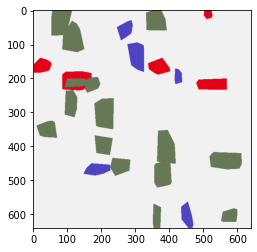

In [5]:
img_b = show(t1)
# img[img>1] = 255
plt.imshow(img_b,'gray')

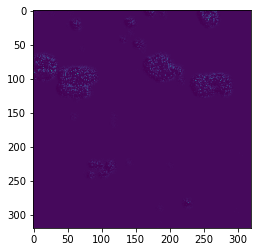

In [6]:
img = show(r1)
plt.imshow(img[:,:,0])